In [5]:

%pprint
import pandas as pd

tables_url = r'https://ballotpedia.org/List_of_current_mayors_of_the_top_100_cities_in_the_United_States'
file_path = r'../data/html/Mayors_of_Americas_100_Largest_Cities.html'
mayors_df_list = pd.read_html(file_path)
mayors_df = mayors_df_list[0]
mayors_df = mayors_df.droplevel(0, axis='columns')

In [21]:

import re

party_regex = re.compile(r'[^)(]+\(([^)(])\)')
def get_party(x):
    mayor_str = str(x)
    match_obj = party_regex.search(mayor_str)
    if match_obj:
        mayor_party = match_obj.group(1)
    else:
        mayor_party = pd.np.nan
    
    return mayor_party

mayors_df['Party'] = mayors_df['Mayor'].map(get_party)

In [29]:

count_series = mayors_df.groupby('Party').count()
count_series

,Rank,City,Mayor,Took office,Term ends,Government type
Party,,,,,,
D,62,62,62,62,62,62
I,4,4,4,4,4,4
R,30,30,30,30,30,30


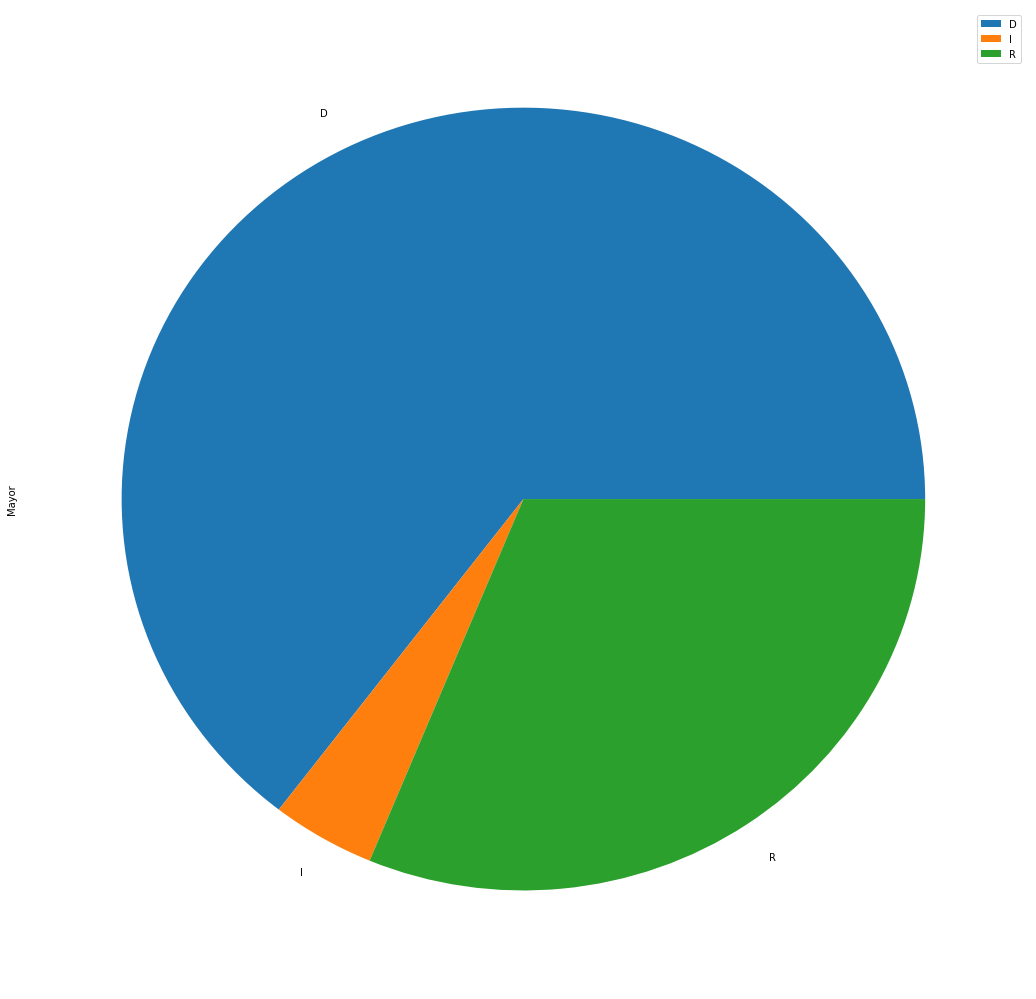

In [30]:

%matplotlib inline

plot = count_series.plot.pie(y='Mayor', figsize=(18, 18))
plot


I had to perform a lot of <a href='https://secure.i.telegraph.co.uk/multimedia/archive/02152/panda-upside-down_2152868i.jpg' target='_blank'>panda gymnastics</a> in order to clean off the husk of the Google table and get the data into a compact space.

In [2]:

tribes_df = tribes_df_list[0].dropna(axis=0, how='all').dropna(axis=1, how='all').iloc[:, 1:]
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.sample(3).T.sample(6).T

,FOREBEARS,EXISTENTIAL THREATS,TELOS,SACRED VALUES,COMBATANTS,CAMPFIRE
MEMETIC TRIBE,,,,,,
Alt-Lite,Cultural Libertarianism,Death of Western Civilization,Unapologetic free speech,"Free Speech, Western Monoculturism","SJAs, #MeToo, Black Lives Matter, Antifa","Twitter, Gabber, Reddit"
Black Lives Matter,"Audre Lorde, Franz Fanon, Malcolm X",Systemic racism,Justice for racialized people,Restorative Justice,"Alt-Lite, Alt-Right, Trumpists, Establishment ...","Protests, Campuses, Twitter"
MGTOW (Men Going Their Own Way),Esther Vilar,Gynocentrism,Societal and relational disengagement,Freedom (from women),"Manosphere, SJA, Gender-Critical Feminists",MGTOW Central



It's an easy matter to add the tribes into a directional graph.

In [3]:

import networkx as nx

tribes_digraph = nx.DiGraph()
tribes_digraph.add_nodes_from(tribes_df.T.to_dict())


Next is figuring out, from the combatant lists, where the edges are.

In [4]:

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

tribe_list = tribes_df.index.tolist()
for row_index, row_value in tribes_df['COMBATANTS'].iteritems():
    combatant_list = row_value.split(', ')
    for combatant in combatant_list:
        if combatant != 'None':
            
            # The combatants are in slightly differing spellings,
            # so I need to just guess which one I mean
            this_tribe = sorted(tribe_list,
                                key=lambda tribe: similar(combatant, tribe.split(' (')[0]))[-1]
            
            tribes_digraph.add_edge(row_index, this_tribe)


I have to use Gephi to get every node away from the other edges because `networkx` doesn't do that well enough.

In [5]:

import os

# Export the graph into Gephi
SAVES_FOLDER = '../saves/'
gexf_dir = os.path.join(SAVES_FOLDER, 'gexf')
os.makedirs(name=gexf_dir, exist_ok=True)
file_name = 'tribes_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)
nx.write_gexf(tribes_digraph, file_path)
message_str = '''
1) Launch Gephi
2) In the File menu, open {}
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and overwrite the old {}
6) Repeat 2) through 5) as necessary
'''
print(message_str.format(os.path.abspath(file_path), file_name))


1) Launch Gephi
2) In the File menu, open C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\gexf\tribes_digraph.gexf
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and overwrite the old tribes_digraph.gexf
6) Repeat 2) through 5) as necessary




I have decided to color the mutual combatants' edge red. For this I need a list of edges that have arrows pointing both ways.

In [6]:

full_edge_list = list(tribes_digraph.edges())
double_edge_list = []
while len(full_edge_list) > 0:
    edge_tuple = full_edge_list.pop()
    doubled_tuple = (edge_tuple[1], edge_tuple[0])
    if doubled_tuple in full_edge_list:
        double_edge_list.append(edge_tuple)
        double_edge_list.append(doubled_tuple)

In [7]:

single_edge_list = []
full_edge_list = list(tribes_digraph.edges())
for edge_tuple in full_edge_list:
    if edge_tuple not in double_edge_list:
        single_edge_list.append(edge_tuple)

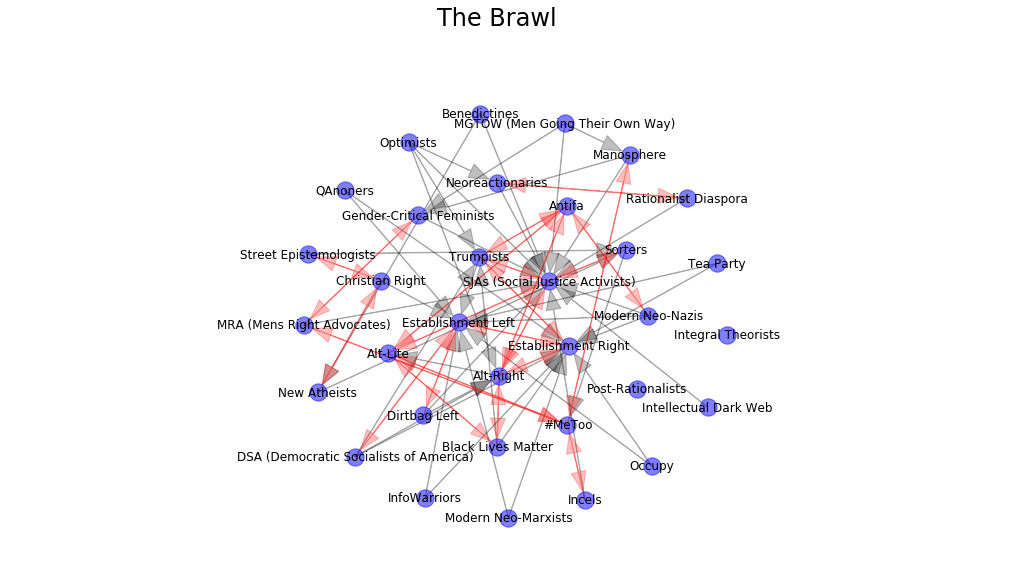

In [8]:

import xmltodict
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

# Import from Gephi
with open(file_path, 'r') as fid:
    tribal_xml = fid.read()
tribal_tree = xmltodict.parse(tribal_xml)

# Get the position dictionary for the GEXF saved from Gephi
node_dict_list = tribal_tree['gexf']['graph']['nodes']['node']
tribal_layout_dict = {node_dict['@id']: np.array([float(node_dict['viz:position']['@x']),
                                                  float(node_dict['viz:position']['@y'])])
                      for node_dict in node_dict_list}

# Draw the graph using the gephi layout
tribal_fig = plt.figure(figsize=(18, 9))
ax = tribal_fig.add_subplot(111)
plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])
tribal_fig.suptitle('The Brawl', fontsize=24)

# Make fat arrows
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)

# Make the nodes blue so you can make the double edges red
node_collection = nx.draw_networkx_nodes(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.5,
                                         node_color='b')

# Get the double-edged edge list in red
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=single_edge_list)
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=double_edge_list,
                                         edge_color='r')

labels_collection = nx.draw_networkx_labels(G=tribes_digraph, pos=tribal_layout_dict, font_size=12)
axes_subplot = tribal_fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1500, right=1500)

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [11]:
# %load ../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/'
notebook_viewer_url += '/'.join(notebook_path.split('/')[1:])
html_str = '''Click
    <a href="{}" target="_blank">here</a>
to view notebook in nbviewer.'''.format(notebook_viewer_url)
HTML(html_str)